In [34]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import scipy.stats as st
from statsmodels.stats.multitest import multipletests
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sns.set_theme(font_scale = 1, style = 'ticks')



# Plot results for figure 3 and supplements

In [35]:
git_folder = Path('../..')
figure_folder = git_folder / 'Figures' /'KEIO'
figure_folder.mkdir(parents=True, exist_ok=True)
data_folder_1 = git_folder / 'data' / 'this_project' / '2_keio_strains_screening'
fn_tubes = data_folder_1 / '2A_ecoli_KO_screen_tubes_OD.csv'
fn_wells = data_folder_1 / '2B_ecoli_KO_screen_wells_OD.csv'

z_scores_fn = data_folder_1 / '2E_exometabolome_zscores.csv'
uM_fn = data_folder_1 / '2C_exometabolome_uM.csv'
counts_fn = data_folder_1 / '2D_exometabolome_counts.csv'

# Plot exometabolome comparisons

In [36]:
df_uM = pd.read_csv(uM_fn, index_col=0, nrows=27)
df_z_scores = pd.read_csv(z_scores_fn, index_col=0)
df_counts = pd.read_csv(counts_fn, index_col=0)


In [37]:
# Drop metabolites not detected in any condition
df_uM = df_uM.loc[:, df_uM.notna().any()]
df_z_scores = df_z_scores.loc[:, df_z_scores.notna().any()]
df_counts = df_counts.loc[:, df_counts.notna().any()]

In [38]:
# move pool samples to a separate df
df_uMpools = df_uM.loc[df_uM.Sample_id.str.contains('pool')]
df_uMsamples = df_uM.loc[~df_uM.Sample_id.str.contains('pool')]

df_z_scores_pools = df_z_scores.loc[df_z_scores.Sample_id.str.contains('pool')]
df_z_scores_samples = df_z_scores.loc[~df_z_scores.Sample_id.str.contains('pool')]

df_counts_pools = df_counts.loc[df_counts.Sample_id.str.contains('pool')]
df_counts_samples = df_counts.loc[~df_counts.Sample_id.str.contains('pool')]

## Plot pairwise comparison of strain vs WT


In [39]:
exo_strains = sorted(df_uMsamples.Strain.unique())
exo_strains_x_wt = [x for x in exo_strains if 'WT' not in x]
exo_strains_x_wt = [x for x in exo_strains_x_wt if 'lacA' not in x] + ['lacA']

uM_metabolites = sorted(df_uMsamples.columns[1:-5])
z_metabolites = sorted(df_z_scores.columns[1:-5])

In [40]:
df_uMsamples.set_index('Strain', inplace=True)
df_counts_samples.set_index('Strain', inplace=True)


In [41]:
strain_cmap =plt.get_cmap('tab10', 9)
strain_colors = {
    'WT': strain_cmap(0),
    'aceE': strain_cmap(1),
    'cyoD': strain_cmap(2),
    'nuoA': strain_cmap(3),
    'pgi': strain_cmap(4),
    'rpe': strain_cmap(5),
    'sucB': strain_cmap(7),
    'lacA': strain_cmap(6),
}


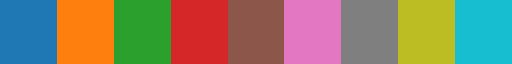

In [42]:
strain_cmap

## Compute p-values

In [43]:

# Collect p-values and corresponding (strain, metabolite) pairs
strain_metabolite_pairs = []
adjusted_p_values = []
all_p_values = []
uM_mean_std_dict = {}
for strain in exo_strains:
    p_values = []
    for metabolite in uM_metabolites:
        s_values = df_uMsamples.loc[strain, metabolite]
        wt_values = df_uMsamples.loc['WT', metabolite]
        s_mean = s_values.mean()
        wt_mean = wt_values.mean()
        s_std = s_values.std()
        wt_std = wt_values.std()
        uM_mean_std_dict[strain, metabolite] = {'Mean':s_mean, 'Std':s_std, 'N':len(s_values)}
        
        # if not np.isnan([s_mean, wt_mean, s_std, wt_std]).any():
        ttest_res = st.ttest_ind(s_values, wt_values, equal_var=False, alternative='two-sided')
        if not np.isnan(ttest_res.pvalue):
            p_values.append(ttest_res.pvalue)
            strain_metabolite_pairs.append((strain, metabolite))
        
    # Adjust p-values using the Benjamini-Hochberg procedure
    adjusted_p_values_s = multipletests(p_values, method='fdr_bh')[1]
    adjusted_p_values += adjusted_p_values_s.tolist()
    all_p_values += p_values
    # break
# Create a dictionary with adjusted p-values
adjusted_p_values_dict = {
    pair: adj_p for pair, adj_p in zip(strain_metabolite_pairs, adjusted_p_values)
}
p_values_dict = {
    pair: p_val for pair, p_val in zip(strain_metabolite_pairs, all_p_values)
}


In [44]:

# Collect p-values and corresponding (strain, metabolite) pairs
strain_metabolite_pairs = []
adjusted_p_values = []
all_p_values = []
counts_mean_std_dict = {}
all_mean_differences = {}
log_diffs = {}
for strain in exo_strains:
    p_values = []
    for metabolite in z_metabolites:
        s_values = df_counts_samples.loc[strain, metabolite]
        wt_values = df_counts_samples.loc['WT', metabolite]
        s_mean = s_values.mean()
        wt_mean = wt_values.mean()
        s_std = s_values.std()
        wt_std = wt_values.std()
        counts_mean_std_dict[strain, metabolite] = {'Mean':s_mean, 'Std':s_std, 'N':len(s_values)}
        # if not np.isnan([s_mean, wt_mean, s_std, wt_std]).any():
        if strain != 'WT':
            log_diffs[strain, metabolite] = np.log10(s_mean) - np.log10(wt_mean)
            all_mean_differences[strain, metabolite] = s_mean - wt_mean
        ttest_res = st.ttest_ind(s_values, wt_values, equal_var=False, alternative='two-sided')
        if not np.isnan(ttest_res.pvalue):
            p_values.append(ttest_res.pvalue)
            strain_metabolite_pairs.append((strain, metabolite))
        
        # print(strain, metabolite, ttest_res, s_values, wt_values)
    # Dont add WT vs WT in all the values
    # Adjust p-values using the Benjamini-Hochberg procedure
    adjusted_p_values_s = multipletests(p_values, method='fdr_bh')[1]
    adjusted_p_values += adjusted_p_values_s.tolist()
    all_p_values += p_values
    # break
# Create a dictionary with adjusted p-values
counts_adjusted_p_values_dict = {
    pair: adj_p for pair, adj_p in zip(strain_metabolite_pairs, adjusted_p_values)
}
counts_p_values_dict = {
    pair: p_val for pair, p_val in zip(strain_metabolite_pairs, all_p_values)
}


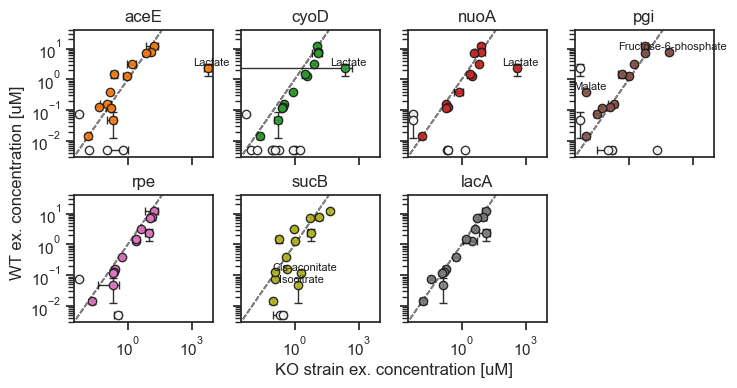

In [45]:
from matplotlib.ticker import LogLocator, NullFormatter

fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex = True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    for j, m in enumerate(uM_metabolites):
        # print(strain, m)
        ax = axes[i]
        ax.set_title(strain)
        ax.set_xscale('log')
        ax.set_yscale('log')
        s_mean = uM_mean_std_dict[strain, m]['Mean']
        s_std = uM_mean_std_dict[strain, m]['Std']
        s_n = uM_mean_std_dict[strain, m]['N']
        wt_mean = uM_mean_std_dict['WT', m]['Mean']
        wt_std = uM_mean_std_dict['WT', m]['Std']
        wt_n = uM_mean_std_dict['WT', m]['N']

        if np.isnan(s_mean) and np.isnan(wt_mean):
            continue

        try:
            pvalue = p_values_dict[strain, m]
        except:
            pvalue = np.nan
        
        # if pvalue < 0.05:
        #     print(f'{strain} {m} {ttest_res.pvalue:.2e}')
        #     mecolor = 'k'
        # else:
        #     mecolor = 'gray'

        mecolor = 'k'
        if np.isnan(s_mean) or np.isnan(wt_mean):
            c = 'w'
            if np.isnan(s_mean):
                s_mean = 5e-3
            if np.isnan(wt_mean):
                wt_mean = 5e-3
        else:
            c = strain_colors[strain]


        ax.errorbar(
            x=s_mean,
            y = wt_mean,
            xerr=s_std,
            yerr=wt_std,
            fmt='o',
            # color='black',
            capsize=3,
            elinewidth=1,
            alpha=0.9,
            markeredgecolor=mecolor,
            ecolor=mecolor,#wt_mets_colors[m],
            c = c#strain_colors[strain],
        )
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([1e-4, 1e3], [1e-4, 1e3], ls = '--',c = 'gray', alpha=0.5, zorder=-10, lw = 1)


        # Annotate
        if np.abs(np.log10(uM_mean_std_dict[strain, m]['Mean']) - np.log10(uM_mean_std_dict['WT', m]['Mean'])) > 1:
            ax.annotate(
                m,
                xy=(uM_mean_std_dict[strain, m]['Mean'], uM_mean_std_dict['WT', m]['Mean']),
                xytext=(uM_mean_std_dict[strain, m]['Mean']*1.5, uM_mean_std_dict['WT', m]['Mean']*1.5),
                fontsize=8,
                ha='center',
                va='center',
                color = 'k', #strain_colors[strain],
            )
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(3e-3, 1e4)
        ax.set_ylim(3e-3, 4e1)
        # ax.set_ylim(-4, 4)
        # Increase the number of ticks on the x-axis
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        # ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=6))  # Minor ticks

axes[-1].remove()
fig.supylabel('WT ex. concentration [uM]', fontsize=12)
fig.supxlabel('KO strain ex. concentration [uM]', fontsize=12)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, left = 0.1, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_exometabolome_wt_comparison_v1.pdf', bbox_inches='tight')

# Repeat, but with counts

aceE 3-(4-hydroxyphenyl)pyruvate 4.63e-02
aceE 3-hydroxyanthranilate 3.96e-02
aceE 3-hydroxybutyrate 2.62e-04
aceE 3-hydroxyglutaric acid 3.96e-02
aceE 4-acetamidobutanoate 2.68e-02
aceE Aicar 2.68e-02
aceE Allantoin 3.96e-02
aceE Dethiobiotin 2.69e-02
aceE Dihydroorotate 3.96e-02
aceE Ethanolamine 2.16e-02
aceE Fructose-6-phosphate 2.68e-02
aceE Lactate 3.96e-02
aceE Malate 3.96e-02
aceE Mannose 3.96e-02
aceE Methylguanidine 3.96e-02
aceE N,n,n-trimethyllysine 3.96e-02
aceE N-acetylserine 3.96e-02
aceE NAD 3.96e-02
aceE Pyridoxal 2.45e-02
aceE S-adenosylhomocysteine 2.94e-02
aceE S-adenosylmethionine 3.96e-02
aceE cAMP 1.39e-03
cyoD 2-hydroxyglutaric acid 2.81e-02
cyoD 3-hydroxyanthranilate 3.94e-02
cyoD 3-hydroxyglutaric acid 2.81e-02
cyoD 4-acetamidobutanoate 4.56e-02
cyoD Adenosine 2.81e-02
cyoD Alanine 4.56e-02
cyoD Cis-aconitate 4.91e-02
cyoD Guanidinosuccinate 4.56e-02
cyoD Histidinol 3.71e-02
cyoD Hypoxanthine 3.78e-02
cyoD Leucine 3.94e-02
cyoD Malate 2.81e-02
cyoD Oxoproline 

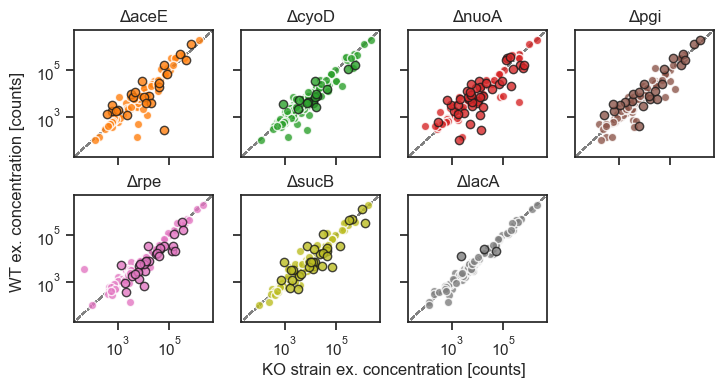

In [65]:
annotate = False
fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex = True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    for j, m in enumerate(z_metabolites):
        ax = axes[i]
        ax.set_title(f'Δ{strain}')
        ax.set_xscale('log')
        ax.set_yscale('log')
        s_mean = counts_mean_std_dict[strain, m]['Mean']
        wt_mean = counts_mean_std_dict['WT', m]['Mean']

        if np.isnan(s_mean) or np.isnan(wt_mean):
            c = 'w'
            if np.isnan(s_mean):
                s_mean = 1
            if np.isnan(wt_mean):
                wt_mean = 1
        else:
            c = strain_colors[strain]

        try:
            pvalue = counts_adjusted_p_values_dict[strain, m]
        except:
            pvalue = np.nan
        
        if pvalue < 0.05:
            print(f'{strain} {m} {pvalue:.2e}')
            mecolor = 'k'
            zorder = 10
        else:
            mecolor = 'w'
            zorder = 1

        # mecolor = 'k'
        ax.errorbar(
            x=s_mean,
            y=wt_mean,
            # xerr=counts_mean_std_dict[strain, m]['Std'],
            # yerr=counts_mean_std_dict['WT', m]['Std'],
            fmt='o',
            # color='black',
            capsize=3,
            elinewidth=1,
            alpha=0.8,
            markeredgecolor=mecolor,
            ecolor=mecolor,#wt_mets_colors[m],
            c = c,
            zorder=zorder,
        )
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([1e-2, 1e7], [1e-2, 1e7], ls = '--',c = 'gray', alpha=0.5, zorder=-10, lw = 1)

        # Annotate
        if annotate:
            if np.abs(np.log10(s_mean) - np.log10(wt_mean)) > 1:
                ax.annotate(
                    m,
                    xy=(counts_mean_std_dict[strain, m]['Mean'], counts_mean_std_dict['WT', m]['Mean']),
                    xytext=(counts_mean_std_dict[strain, m]['Mean']*1.5, counts_mean_std_dict['WT', m]['Mean']*1.5),
                    fontsize=8,
                    ha='center',
                    va='center',
                    # fontweight='bold',
                    color = 'k', #strain_colors[strain],
                )
        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(20, 5e6)
        ax.set_ylim(20, 5e6)
        # ax.set_ylim(-4, 4)
        # Increase the number of ticks on the x-axis
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        # ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=6))  # Minor ticks

axes[-1].remove()
fig.supylabel('WT ex. concentration [counts]', fontsize=12)
fig.supxlabel('KO strain ex. concentration [counts]', fontsize=12)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, left = 0.1, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_exometabolome_wt_comparison_v1_counts.pdf', bbox_inches='tight')

In [47]:
df_log_diffs = pd.Series(log_diffs).reset_index()
df_log_diffs.columns = ['Strain', 'Metabolite', 'LogDiff']

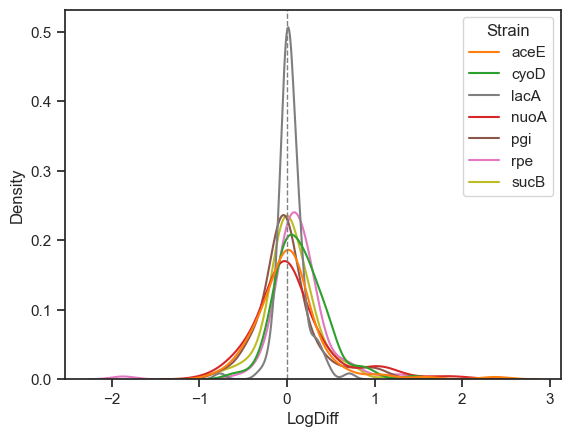

In [48]:
# log_diff = 
ax = sns.kdeplot(data = df_log_diffs, x = 'LogDiff', hue = 'Strain', palette=strain_colors)
ax.axvline(0, ls = '--', c = 'gray', lw = 1)


In [49]:
df_log_diffs.dropna(inplace=True)

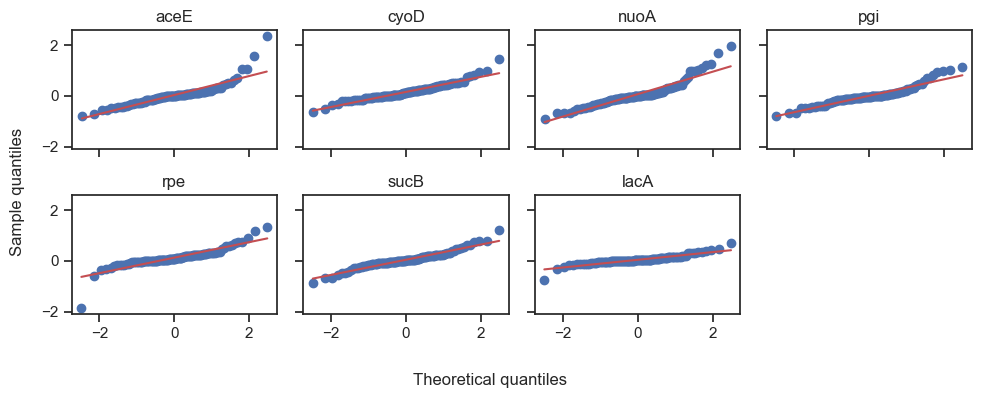

In [50]:
fig, axes = plt.subplots(2, 4, figsize=(10, 4), sharex=True, sharey=True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    ax = axes[i]
    df_log_diffs_s = df_log_diffs.loc[df_log_diffs.Strain == strain]
    # print(df_log_diffs_s)
    # print(st.probplot(df_log_diffs_s.LogDiff, dist="norm", plot=plt, ))
    st.probplot(df_log_diffs_s.LogDiff, dist="norm", plot=ax, fit = True)#, rvalue=True)
    ax.set_title(strain)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xlim(-3, 3)
    # ax.set_ylim(-3, 3)
fig.supxlabel('Theoretical quantiles', fontsize=12)
fig.supylabel('Sample quantiles', fontsize=12)
axes[-1].remove()
plt.tight_layout()
# st.probplot(df_log_diffs.LogDiff, dist="norm", plot=plt, )

In [51]:

wt_mets = sorted(df_uM.loc[df_uM.Strain == 'WT', df_uM.loc[df_uM.Strain == 'WT'].notna().any()].columns[1:-4])

In [52]:
mets_cmap = plt.get_cmap('tab20', len(wt_mets))
wt_mets_colors = {m: mets_cmap(i) for i, m in enumerate(wt_mets)}

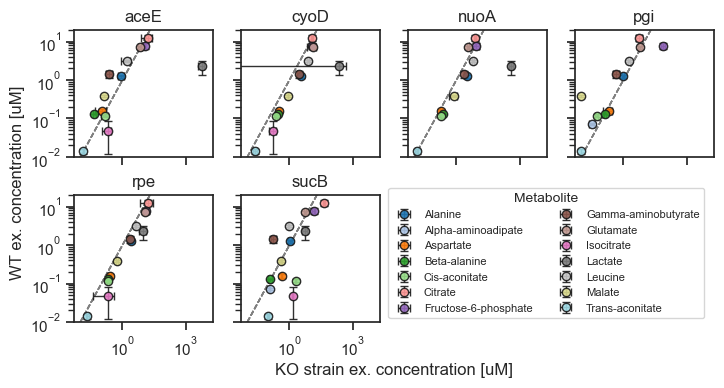

In [53]:
from matplotlib.ticker import LogLocator, NullFormatter

fig, axes = plt.subplots(2, 4, figsize=(8, 4), sharey=True, sharex = True)
axes = axes.flatten()
for i, strain in enumerate(exo_strains_x_wt):
    if strain == 'lacA':
        continue
    for j, m in enumerate(uM_metabolites):
        ax = axes[i]
        ax.set_title(strain)
        ax.set_xscale('log')
        ax.set_yscale('log')
        x_mean = uM_mean_std_dict[strain, m]['Mean']
        y_mean = uM_mean_std_dict['WT', m]['Mean']
        if np.isnan(x_mean) or np.isnan(y_mean):
            continue
        ax.errorbar(
            x=x_mean,
            y=y_mean,
            xerr=uM_mean_std_dict[strain, m]['Std'],
            yerr=uM_mean_std_dict['WT', m]['Std'],
            fmt='o',
            # color='black',
            capsize=3,
            elinewidth=1,
            alpha=0.9,
            markeredgecolor='k',
            ecolor='k',#wt_mets_colors[m],
            c = wt_mets_colors[m],
            label = m,
        )
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.plot([1e-2, 1e3], [1e-2, 1e3], ls = '--',c = 'gray', alpha=0.5, zorder=-10, lw = 1)

        # ax.set_aspect('equal', adjustable='box')
        ax.set_xlim(5e-3, 2e4)
        ax.set_ylim(1e-2, 2e1)
        # ax.set_ylim(-4, 4)
        # Increase the number of ticks on the x-axis
        ax.xaxis.set_major_locator(LogLocator(base=10.0, numticks=4))  # Major ticks
        # ax.xaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=6))  # Minor ticks

axes[-3].legend(
    loc='upper left',
    bbox_to_anchor=(1.02, 1.1),
    fontsize=8,
    title='Metabolite',
    title_fontsize='10',
    frameon=True,
    ncol=2,
)
axes[-1].remove()
axes[-2].remove()

fig.supylabel('WT ex. concentration [uM]', fontsize=12)
fig.supxlabel('KO strain ex. concentration [uM]', fontsize=12)
# plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.3, left = 0.1, bottom=0.15)
plt.savefig(figure_folder / 'KEIO_exometabolome_wt_comparison_v2.pdf', bbox_inches='tight')

## PCA of z_score


In [54]:
X_df = df_z_scores_samples[z_metabolites].copy()

In [55]:
X_df = X_df.apply(lambda col: col.fillna(col.min()), axis = 0)

In [56]:
X = StandardScaler().fit_transform(X_df)

pca = PCA(n_components=2)
Xn = pca.fit_transform(X)
pca_df = pd.DataFrame(
    data = Xn,
    columns = ['PC1', 'PC2'],
    index = df_z_scores_samples.Sample_id,
)
pca_df['Strain'] = df_z_scores_samples.Strain.values


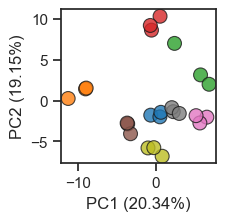

In [57]:
fig, ax = plt.subplots(figsize=(2, 2))
pca_df.sort_values(by = 'Strain', inplace=True)
sns.scatterplot(
    data = pca_df,
    x = 'PC1',
    y = 'PC2',
    hue = 'Strain',
    palette = strain_colors,
    alpha = 0.8,
    edgecolor = 'k',
    s = 100,
    ax=ax,
    legend=False,
    )
ax.set_xlabel('PC1 (%.2f%%)' % (pca.explained_variance_ratio_[0] * 100))
ax.set_ylabel('PC2 (%.2f%%)' % (pca.explained_variance_ratio_[1] * 100))
# sns.despine()
plt.savefig(figure_folder / 'KEIO_exometabolome_pca.pdf', bbox_inches='tight')

# Plot growth curves and yield from tubes

In [58]:
df_od_tubes = pd.read_csv(fn_tubes, index_col=0)
df_od_tubes.rename(columns={'Hours': 'Time [h]'}, inplace=True) 

# only keep data fro strains we did exomtabolome on
df_od_tubes = df_od_tubes.loc[df_od_tubes.Strain.isin(exo_strains)]

# strains = sorted(df_od_tubes.Strain.unique())
replicates = ['A', 'B', 'C']

yield_df = df_od_tubes.groupby(['Strain', 'Replicate']).agg({'OD600': 'max'}).reset_index()

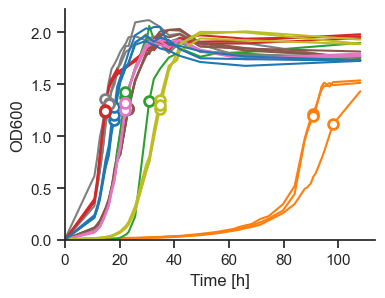

In [59]:
fig, ax = plt.subplots(figsize=(4, 3))
ax = sns.lineplot(data = df_od_tubes, x = 'Time [h]', y = 'OD600', hue = 'Strain',# style = 'Replicate',
                   palette = strain_colors, markers=True, units='Replicate', estimator=None, legend=False)# marker = 'o')
# sns.move_legend(ax, loc = 'upper left', bbox_to_anchor=(1, 1), title = 'Strain', fontsize = 10)
for strain in exo_strains:
    for replicate in replicates:
        idx = (df_uM.Strain == strain) & ( df_uM.Replicate == replicate)
        time = df_uM.loc[idx, 'Hours'].values[0]
        od = df_uM.loc[idx, 'OD'].values[0]
        ax.scatter(
            x = time,
            y = od,
            color = 'w',
            marker = 'o',
            s = 50,
            edgecolor = strain_colors[strain],
            linewidth = 2,
            zorder = 100

            # label = f'{strain} {replicate}',
        )

# plt.yscale('log')
sns.despine()
ax.set_ylim(0)
ax.set_xlim(0)
plt.savefig(figure_folder / '2A_screening_tubes_OD.pdf', bbox_inches='tight')

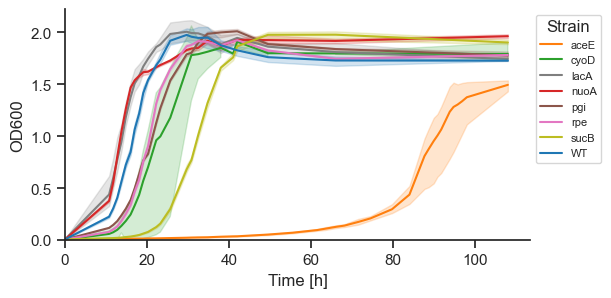

In [60]:
fig, ax = plt.subplots(figsize=(6, 3))
ax = sns.lineplot(data = df_od_tubes, x = 'Time [h]', y = 'OD600', hue = 'Strain', 
                  palette = strain_colors)
sns.move_legend(ax, loc = 'upper left', bbox_to_anchor=(1, 1), title = 'Strain', fontsize = 8)
sns.despine()
ax.set_ylim(0)
ax.set_xlim(0)
plt.savefig(figure_folder / '2A_screening_tubes_OD_error_band.pdf', bbox_inches='tight')

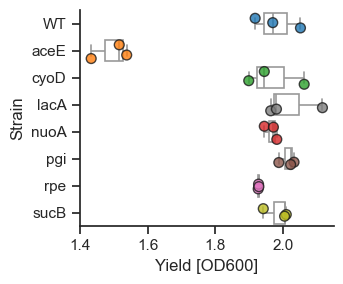

In [61]:

g = sns.catplot(data = yield_df, y = 'Strain', x = 'OD600',hue = 'Strain', 
                aspect=1.2, s = 50, height=3, alpha = 0.8, jitter = 0.3, edgecolor='k',
                  linewidth = 1, palette=strain_colors, order=exo_strains)
g.map_dataframe(sns.boxplot, y = 'Strain', x = 'OD600', color = 'w', fliersize = 0, linewidth = 1.2)
g.set_axis_labels('Yield [OD600]', 'Strain')
plt.savefig(figure_folder / 'strain_yield.pdf', bbox_inches='tight')

### Get growth rates

In [62]:
df_od_tubes

,Sample ID,Strain,Time [h],OD600,Replicate
0,1A,aceE,0.0,0.008,A
1,1B,aceE,0.0,0.003,B
2,1C,aceE,0.0,0.007,C
3,2A,cyoD,0.0,0.009,A
4,2B,cyoD,0.0,0.006,B
...,...,...,...,...,...
1375,8B,sucB,108.0,1.891,B
1376,8C,sucB,108.0,1.887,C
1383,11A,WT,108.0,1.726,A
1384,11B,WT,108.0,1.727,B


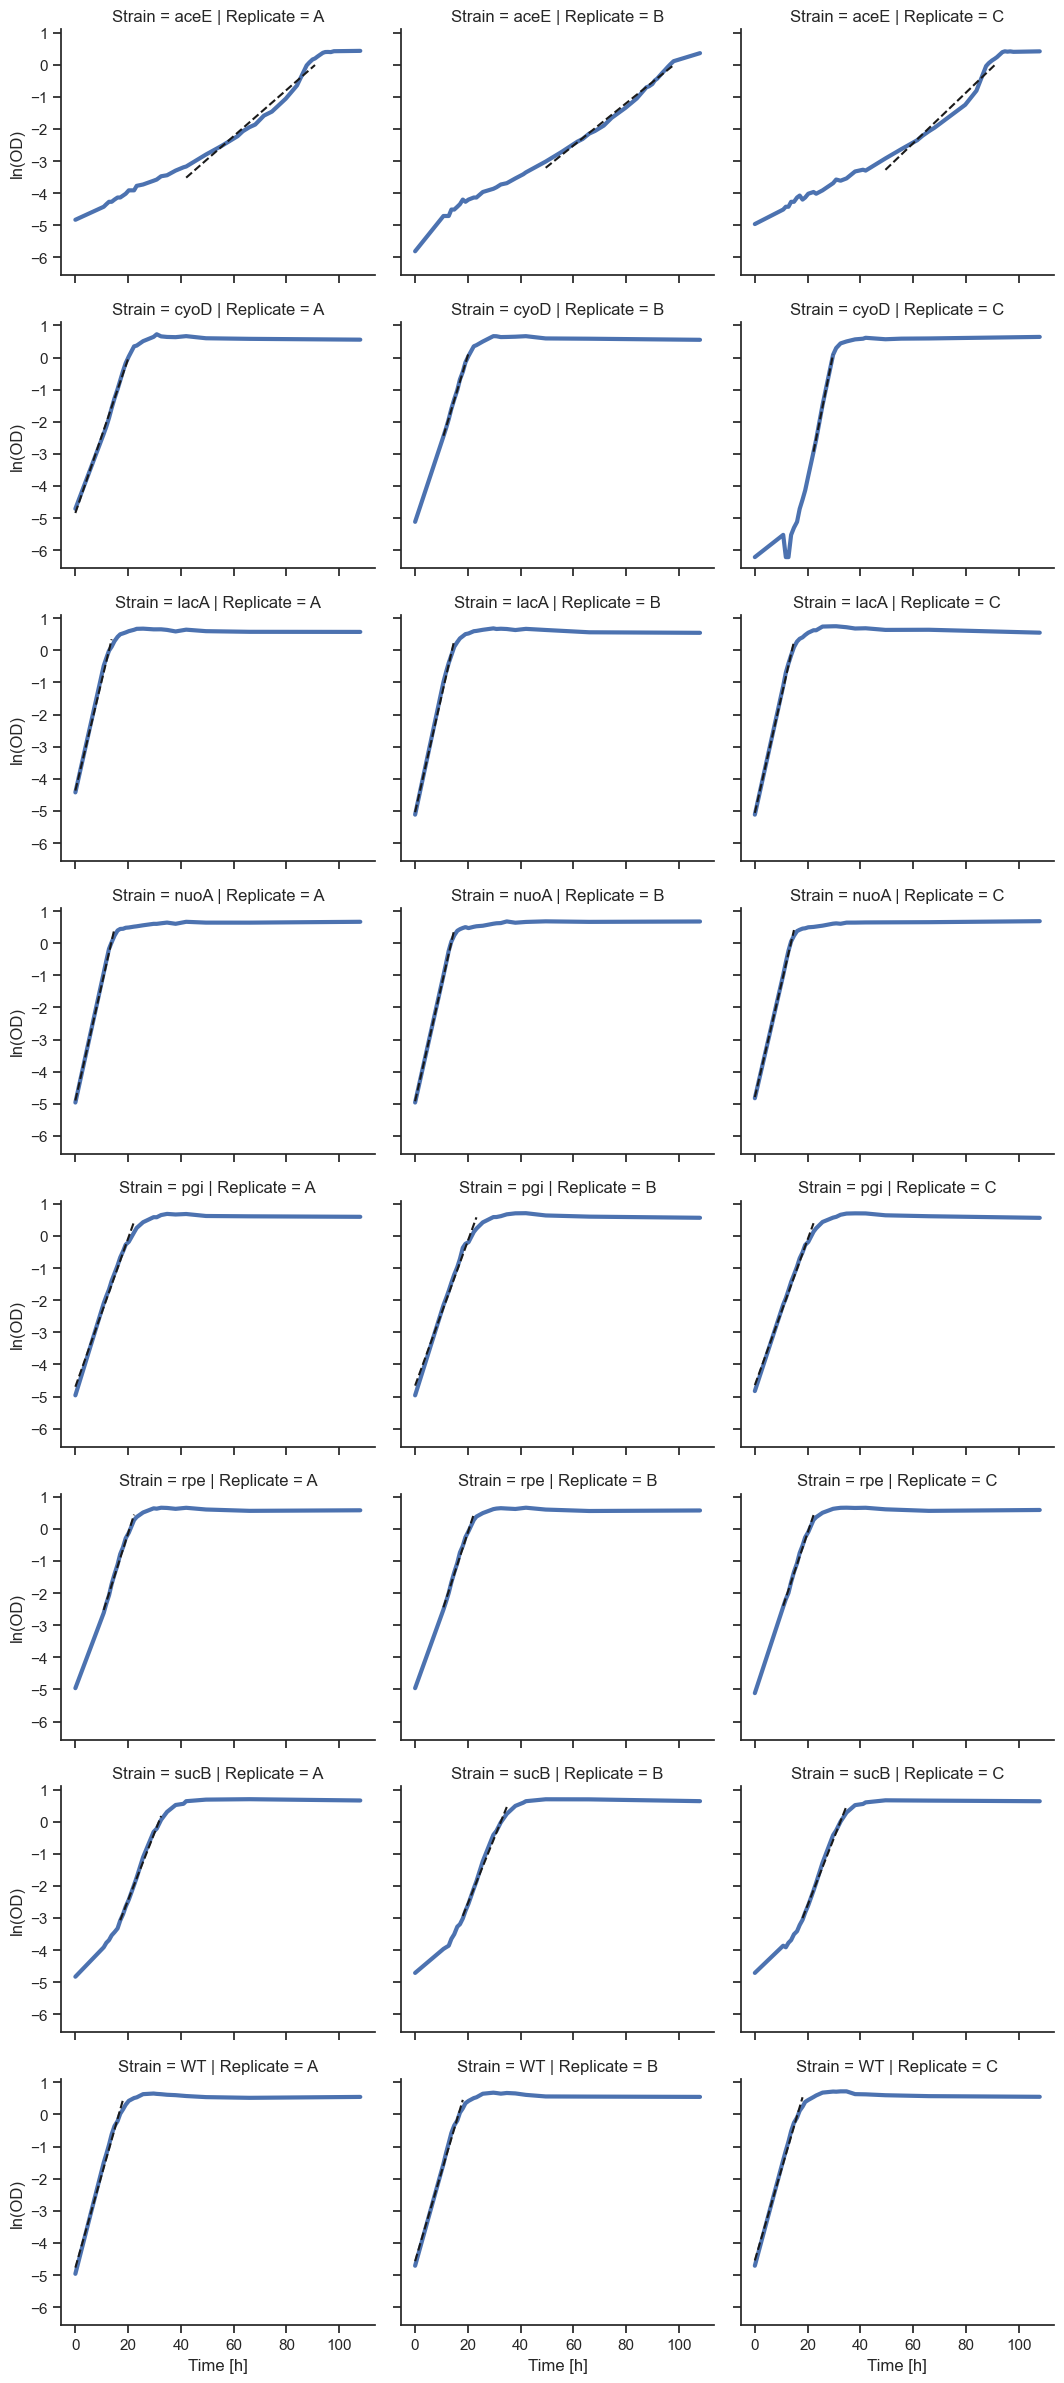

In [63]:
df_od_tubes['ln(OD)'] = np.log([x for x in df_od_tubes['OD600']])
g = sns.relplot(data=df_od_tubes, x = 'Time [h]', y = 'ln(OD)', row = 'Strain', col = 'Replicate', kind = 'line', lw = 3, height = 3, aspect = 1.2)
data = []
od_range = [0.05, 1.2]
for sample_id in df_od_tubes['Sample ID'].unique():
    idx = (df_od_tubes['Sample ID']==sample_id)
    dfi = df_od_tubes.loc[idx]
    strain = dfi.Strain.iloc[0]
    rep = sample_id[-1]
    ax = g.axes_dict[(strain, rep)]
    
    idx0 = (dfi['OD600']-od_range[0]).abs().argmin()
    idx1 = (dfi['OD600']-od_range[1]).abs().argmin()
    
    ln_OD = dfi.iloc[idx0:idx1+1]['ln(OD)']
    hours = dfi.iloc[idx0:idx1+1]['Time [h]']
    fit = np.polyfit(hours, ln_OD, 1)
    x_arr = np.linspace(hours.min(), hours.max(), 2)
    y_arr = x_arr*fit[0]+fit[1]
    # delta_ln_OD = - dfi.iloc[idx0]['ln(OD)']
    # delta_t = dfi.Hours.iloc[idx1]-dfi.Hours.iloc[idx0]
    # growth_rate = delta_ln_OD/delta_t
    growth_rate = fit[0]
    data.append([strain, rep, growth_rate])

    # Plot
    # ax.plot([dfi.Hours.iloc[idx0], dfi.Hours.iloc[idx1]], [dfi.iloc[idx0]['ln(OD)'], dfi.iloc[idx1]['ln(OD)']], c = 'k', ls = '--')
    ax.plot(x_arr, y_arr, c = 'k', ls = '--')
    
df_tube_rate = pd.DataFrame(data, columns = ['Strain', 'Replicate', 'Growth rate'])       

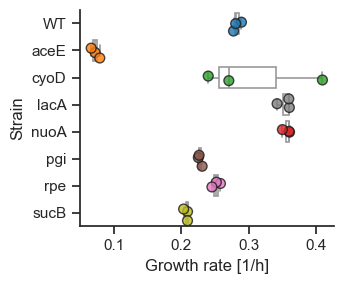

In [64]:



g = sns.catplot(df_tube_rate, x = 'Growth rate', y = 'Strain', hue = 'Strain', order = exo_strains, palette=strain_colors,
                aspect=1.2, s = 50, height=3, alpha = 0.8, jitter = 0.3, edgecolor='k',
                  linewidth = 1)
g.map_dataframe(sns.boxplot, y = 'Strain', x = 'Growth rate', color = 'w', fliersize = 0, linewidth = 1.2)
g.set_axis_labels('Growth rate [1/h]', 'Strain')
plt.savefig(figure_folder / 'strain_rate.pdf', bbox_inches='tight')